<div style="display: flex; align-items: center;">
    <div style="display: flex; flex-direction: column; align-items: center;">
        <h1 style="text-align: right;">Centro de Investigación en Matemáticas, A.C.</h1>
        <h2 style="text-align: right;">Reconocimiento de Patrones</h2>
        <h3 style="text-align: right;">Proyecto</h3>
    </div>
    <img src="Figures\logoCIMAT11.png" alt="CIMAT Logo" width="200" style="float: left;">
</div>


---

0. Cambiar el formato (a long)
1. Agregar variable (etiqueta)
1.1 Alonzo
1.2 Buscar regresión para explicar pregunta 1

2. verificar el % de tiempo en que están a cierta capacidad. graficar (%Capacidad , %tiempo)

3. sen y cos por día y por hora

4. revisar T-SNE

En este proyecto nos interesa contestar las siguientes preguntas:

1. ¿Cuáles son los mejores y/o peores horarios para encontrar estacionaiento en Guanajuato?
2. ¿Hay alguna diferencia entre los estacionamientos del centro de Guanajuato con el resto?
3. ¿Algún estacionamiento se vería beneficiado en aumentar su capacidad?

# Pregunta 1
¿Cuáles son los mejores y/o peores horarios para encontrar estacionaiento en Guanajuato?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns;
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn import manifold
import statsmodels.api as sm
import statsmodels.othermod.betareg as betareg
from sklearn.metrics import r2_score, mean_squared_error

np.random.seed(2025)

# Pregunta 2
¿Hay alguna diferencia entre los estacionamientos del centro de Guanajuato con el resto?

# Pregunta 3
¿Algún estacionamiento se vería beneficiado en aumentar su capacidad?

Claramente, Hinojo sería el más beneficiado si aumentara su capacodad.

Por otro lado, Pozuelos y Leon, le perderian.

In [ ]:
# Load the 'sat.csv' file into a DataFrame, using the first column as the index
est = pd.read_csv('disponibilidad_estacionamientos_final.csv')
MaxEst = pd.read_csv('MaxEst.csv')

# Drop any rows with missing values from the DataFrame
est = est.dropna()


In [ ]:
est.head()

,Fecha_Hora,Gto-Alhondiga,Gto-Alonso,Gto-Hinojo,Gto-Pozuelos,Gto-SanPedro,Irapuato-Hidalgo,Leon-Mariachi
0,2025-02-19 15:15:15,147,32,45,475,214,178,119
1,2025-02-19 15:20:15,145,32,45,482,210,179,117
2,2025-02-19 15:25:16,149,32,44,483,212,178,120
3,2025-02-19 15:30:16,148,33,43,484,214,178,122
4,2025-02-19 15:35:17,148,37,45,490,212,176,123


In [ ]:
column_names = est.columns.tolist()[1:]

print(column_names)

['Gto-Alhondiga', 'Gto-Alonso', 'Gto-Hinojo', 'Gto-Pozuelos', 'Gto-SanPedro', 'Irapuato-Hidalgo', 'Leon-Mariachi']


In [ ]:
est['Fecha_Hora'] = pd.to_datetime(est['Fecha_Hora'])

In [ ]:
est_ratio = np.maximum(1 - est[column_names].div(MaxEst[column_names].values, axis=1),0)

est_ratio['Date_Time'] = est['Fecha_Hora'].apply(lambda x: pd.to_datetime(x).timestamp()/(3600*24))

# Extract weekday and time into separate columns
est_ratio['Weekday'] = est['Fecha_Hora'].dt.weekday  # Monday=0, Sunday=6

est_ratio['Time'] = (est_ratio['Date_Time'] - np.floor(est_ratio['Date_Time']))


In [ ]:

est_ratio['Time_sin'] = np.sin(2 * np.pi * est_ratio['Time'])
est_ratio['Time_cos'] = np.cos(2 * np.pi * est_ratio['Time'])

est_ratio['Date_Time'] = est_ratio['Date_Time'] - est_ratio['Date_Time'][0]

# Cyclic encoding for 'Weekday'
est_ratio['Weekday_sin'] = np.sin(2 * np.pi * est_ratio['Weekday'] / 7)
est_ratio['Weekday_cos'] = np.cos(2 * np.pi * est_ratio['Weekday'] / 7)

# Drop the original 'Weekday' column
est_ratio.drop(columns=['Time','Weekday'], inplace=True)


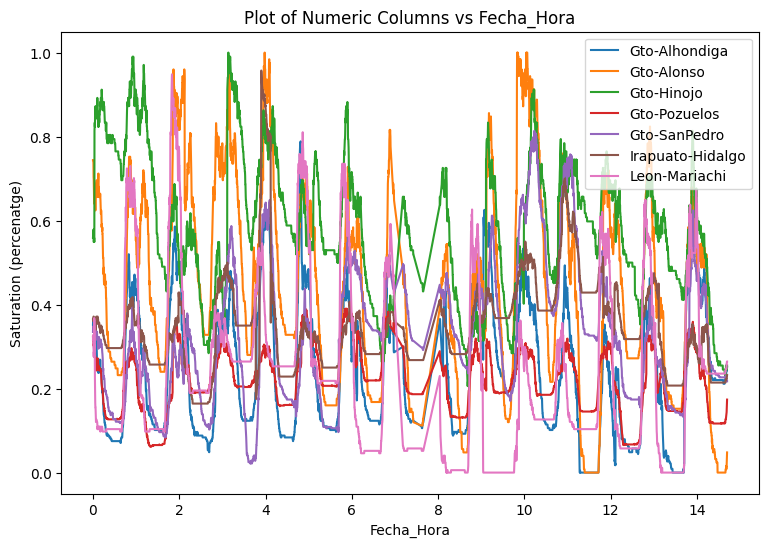

In [ ]:
# Create a single plot with multiple columns
plt.figure(figsize=(9,6))
for col in column_names:
    plt.plot(est_ratio['Date_Time'], est_ratio[col], label=col)

# Set title and labels
plt.title('Plot of Numeric Columns vs Fecha_Hora')
plt.xlabel('Fecha_Hora')
plt.ylabel('Saturation (percenatge)')

# Add legend to differentiate between columns
plt.legend()

# Display the plot
plt.show()

In [ ]:
est_long = est_ratio.melt(id_vars=['Date_Time', 'Time_sin', 'Time_cos', 'Weekday_sin', 'Weekday_cos'],
                   var_name='Parking_Lot',
                   value_name='Saturation')
est_long.drop(columns=['Date_Time'], inplace=True)


In [ ]:
est_long.head()

,Time_sin,Time_cos,Weekday_sin,Weekday_cos,Parking_Lot,Saturation
0,-0.752559,-0.658525,0.974928,-0.222521,Gto-Alhondiga,0.352423
1,-0.766745,-0.641952,0.974928,-0.222521,Gto-Alhondiga,0.361233
2,-0.780612,-0.625016,0.974928,-0.222521,Gto-Alhondiga,0.343612
3,-0.794061,-0.607838,0.974928,-0.222521,Gto-Alhondiga,0.348018
4,-0.807175,-0.590312,0.974928,-0.222521,Gto-Alhondiga,0.348018


In [ ]:
scaler = StandardScaler()
est_scaled = scaler.fit_transform(est_ratio.drop(columns=['Date_Time']))  # Exclude Date_Time


In [ ]:
# Perform PCA to reduce data to 2 dimensions
pca = PCA(n_components=3)
pca_data = pca.fit_transform(est_scaled)


Modificamos la función my_plot proporcionada para que pueda mostrar los puntos con colores distintos dependiendo del agrupamiento.

In [ ]:
def myplot(score,coeff,var_labels=None, points_labels=None):
    # xs and ys are the first two principal components of the score matrix
    xs = score[:,0]
    ys = score[:,1]

    # n is the number of variables in the original data set
    n = coeff.shape[0]

    # scalex and scaley are used to normalize the scores so they fit within a unit square for plotting
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    # Initialize the figure
    plt.figure(figsize=(9, 6))

    # If no points_labels are provided, scatter plot all the scores using different colors
    if points_labels is None:
        plt.scatter(xs * scalex, ys * scaley, cmap='rainbow', s = 1, alpha = 0.2)
    else:
        # If points_labels are provided, scatter plot the scores using different colors based on their labels
        plt.scatter(xs * scalex, ys * scaley, c=points_labels, cmap='rainbow', s = 1, alpha = 0.2)


    # Loop through each variable in the original data set and draw an arrow pointing to its corresponding principal component
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r',alpha = 0.5)

        # If no var_labels are provided, label each principal component with the variable it corresponds to
        if var_labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            # If var_labels are provided, label each principal component with the variable name
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, var_labels[i], color = 'g', ha = 'center', va = 'center')

    # Set the x and y limits of the plot to be within a unit square for better visualization
    plt.xlim(-1,1)
    plt.ylim(-1,1)

    # Label the axes with "PC{}".format(1) and "PC{}".format(2)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))

    # Show a grid on the plot for better readability
    plt.grid()

<ipython-input-97-31f96a5660c3>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xs * scalex, ys * scaley, cmap='rainbow', s = 1, alpha = 0.2)


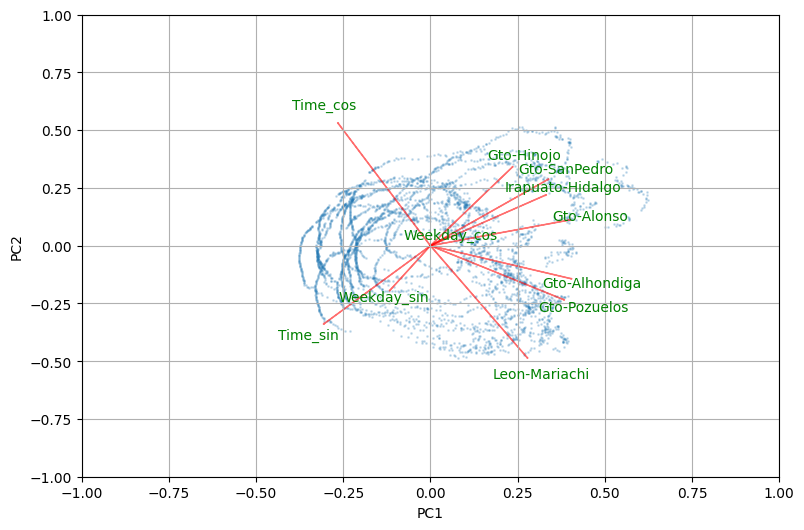

In [ ]:
myplot(pca_data[:,0:2], np.transpose(pca.components_[0:2, :]), var_labels = est_ratio.drop(columns=['Date_Time']).columns.values)

# FFT

In [ ]:
est_FFT = est_ratio.drop(columns=['Time_sin', 'Time_cos', 'Weekday_sin', 'Weekday_cos'])
est_FFT.head()

,Gto-Alhondiga,Gto-Alonso,Gto-Hinojo,Gto-Pozuelos,Gto-SanPedro,Irapuato-Hidalgo,Leon-Mariachi,Date_Time
0,0.352423,0.744,0.558824,0.323362,0.335404,0.364286,0.316092,0.000000
1,0.361233,0.744,0.558824,0.313390,0.347826,0.360714,0.327586,0.003472
2,0.343612,0.744,0.568627,0.311966,0.341615,0.364286,0.310345,0.006956
3,0.348018,0.736,0.578431,0.310541,0.335404,0.364286,0.298851,0.010428
4,0.348018,0.704,0.558824,0.301994,0.341615,0.371429,0.293103,0.013912


In [ ]:
from scipy import fft
from datetime import datetime

def calcular_fft(df, columna_datos='Gto-Alhondiga', columna_tiempo='Date_Time'):
    """
    Calcula la FFT de una columna de datos considerando la relación temporal.

    Parámetros:
    - df: DataFrame de pandas
    - columna_datos: Nombre de la columna con los datos a analizar
    - columna_tiempo: Nombre de la columna con la información temporal

    Retorna:
    - frecuencias: Array con las frecuencias
    - amplitudes: Array con las amplitudes de la FFT
    - df_resultado: DataFrame con las frecuencias y amplitudes
    """
    # Extraer los datos
    y = df[columna_datos].values

    #Ver por que está en segundos
    tiempos = df[columna_tiempo]*900

    # Calcular el intervalo de tiempo promedio en segundos
    delta_t = 1

    # Calcular la FFT
    n = len(y)
    fft_resultado = fft.fft(y)

    # Solo necesitamos la primera mitad del espectro (la segunda mitad es simétrica)
    amplitudes = np.abs(fft_resultado[:n//2]) / n
    # Multiplicamos por 2 para conservar la energía total (excepto para la frecuencia 0)
    amplitudes[1:] = 2 * amplitudes[1:]

    # Calcular las frecuencias correspondientes
    frecuencias = fft.fftfreq(n, delta_t)[:n//2]

    # Crear un DataFrame con los resultados
    df_resultado = pd.DataFrame({
        'Frecuencia': frecuencias,
        'Amplitud': amplitudes
    })

    return frecuencias, amplitudes, df_resultado

# Ejemplo de uso:
# frecuencias, amplitudes, df_resultado = calcular_fft(mi_dataframe)

# Para visualizar los resultados:
def visualizar_fft(frecuencias, amplitudes, titulo="FFT de Gto-Alhondiga"):

    # También mostrar el periodo (1/frecuencia) para las principales componentes
    print("Principales componentes de frecuencia:")
    indices_principales = np.argsort(amplitudes)[-5:]  # Top 5 amplitudes
    for idx in reversed(indices_principales):
        if frecuencias[idx] > 0:  # Ignorar la componente DC
            print(f"Frecuencia: {frecuencias[idx]:.6f} Hz, Periodo: {1/frecuencias[idx]:.2f} segundos, Amplitud: {amplitudes[idx]:.2f}")


In [ ]:
for column in column_names:
    frecuencias, amplitudes, df_resultado = calcular_fft(est_FFT, columna_datos=column)
    print(f"FFT de {column}")
    visualizar_fft(frecuencias, amplitudes, titulo=f"FFT de {column}")

#frecuencias, amplitudes, df_resultado = calcular_fft(est_FFT)
#visualizar_fft(frecuencias, amplitudes)

FFT de Gto-Alhondiga
Principales componentes de frecuencia:
Frecuencia: 0.003685 Hz, Periodo: 271.40 segundos, Amplitud: 0.11
Frecuencia: 0.003193 Hz, Periodo: 313.15 segundos, Amplitud: 0.08
Frecuencia: 0.003439 Hz, Periodo: 290.79 segundos, Amplitud: 0.08
Frecuencia: 0.000737 Hz, Periodo: 1357.00 segundos, Amplitud: 0.06
FFT de Gto-Alonso
Principales componentes de frecuencia:
Frecuencia: 0.003685 Hz, Periodo: 271.40 segundos, Amplitud: 0.17
Frecuencia: 0.003439 Hz, Periodo: 290.79 segundos, Amplitud: 0.14
Frecuencia: 0.000491 Hz, Periodo: 2035.50 segundos, Amplitud: 0.13
Frecuencia: 0.003193 Hz, Periodo: 313.15 segundos, Amplitud: 0.11
FFT de Gto-Hinojo
Principales componentes de frecuencia:
Frecuencia: 0.000737 Hz, Periodo: 1357.00 segundos, Amplitud: 0.08
Frecuencia: 0.003439 Hz, Periodo: 290.79 segundos, Amplitud: 0.08
Frecuencia: 0.003685 Hz, Periodo: 271.40 segundos, Amplitud: 0.08
Frecuencia: 0.001228 Hz, Periodo: 814.20 segundos, Amplitud: 0.07
FFT de Gto-Pozuelos
Principales

In [ ]:
df_resultado


,Frecuencia,Amplitud
0,0.000000,0.235546
1,0.000246,0.102542
2,0.000491,0.046908
3,0.000737,0.034344
4,0.000983,0.026496
...,...,...
2030,0.498649,0.000117
2031,0.498895,0.000158
2032,0.499140,0.000236
2033,0.499386,0.000126


In [ ]:
est_hot = pd.get_dummies(est_long, columns=['Parking_Lot'], dtype = int)


In [ ]:
# Prepare the independent variables (all other columns except 'Saturation')
independent_vars = est_hot.drop(columns=['Saturation'])

# Prepare the dependent variable ('Saturation')
dependent_var = est_hot['Saturation']

# Initialize and fit an OLS model
linear_model = sm.OLS(dependent_var, independent_vars)
linear_result = linear_model.fit()

# Display model summary
print(linear_result.summary())
print("R² Score:", r2_score(dependent_var, linear_result.predict(independent_vars)))
print("Mean Squared Error:", mean_squared_error(dependent_var, linear_result.predict(independent_vars)))


                            OLS Regression Results                            
Dep. Variable:             Saturation   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     3748.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        01:00:32   Log-Likelihood:                 15965.
No. Observations:               28497   AIC:                        -3.191e+04
Df Residuals:                   28486   BIC:                        -3.182e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Time_sin        

In [ ]:
Time_coefficients = np.array(linear_result.params[['Time_sin', 'Time_cos']])

times = np.arange(24)
r = np.pi / 12

Times = np.column_stack((np.sin(r * times), np.cos(r * times)))

time_coeff = Times @ Time_coefficients

Text(0.5, 1.0, 'Time Coefficients over the Day')

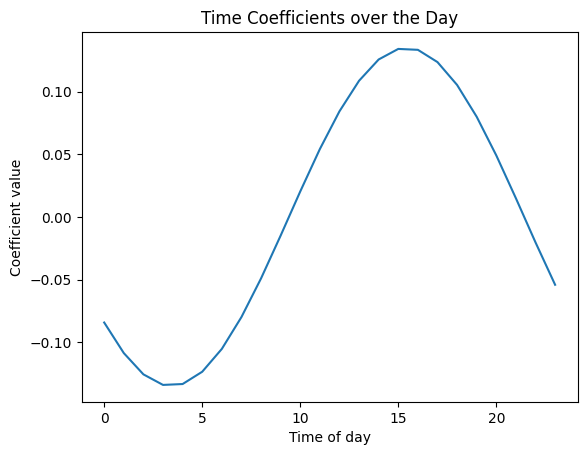

In [ ]:
plt.plot(times, time_coeff)
plt.xlabel('Time of day')
plt.ylabel('Coefficient value')
plt.title('Time Coefficients over the Day')

In [ ]:
Day_coefficients = np.array(linear_result.params[['Weekday_sin', 'Weekday_cos']])

days = np.arange(7)
r = np.pi * 2 / 7

Days = np.column_stack((np.sin(r * days), np.cos(r * days)))

day_coeff = Days @ Day_coefficients

Text(0.5, 1.0, 'Weekday Coefficients over the Day')

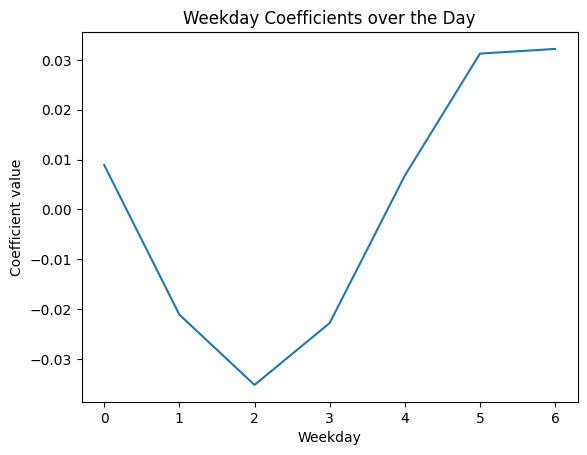

In [ ]:
plt.plot(days, day_coeff)
plt.xlabel('Weekday')
plt.ylabel('Coefficient value')
plt.title('Weekday Coefficients over the Day')

In [ ]:
est_tagged = est_hot

# Define parking lots that should be labeled as "center"
center_lots = ['Gto-Alonso', 'Gto-Hinojo', 'Gto-SanPedro']

# Create the 'center' column in est_tagged
est_center = est_long['Parking_Lot'].isin(center_lots).astype(int)

# Define parking lots that should be labeled as "center"
#gto_lots = ['Gto-Alhondiga', 'Gto-Pozuelos']

# Create the 'center' column in est_tagged
#est_tagged['gto_other'] = est_long['Parking_Lot'].isin(gto_lots).astype(int)

est_tagged['center_Time_sin'] = est_center * est_tagged['Time_sin']
est_tagged['center_Time_cos'] = est_center * est_tagged['Time_cos']
est_tagged['other_Time_sin'] = (1 - est_center) * est_tagged['Time_sin']
est_tagged['other_Time_cos'] = (1 - est_center) * est_tagged['Time_cos']

#est_tagged['center_Weekday_sin'] = est_center * est_tagged['Weekday_sin']
#est_tagged['center_Weekday_cos'] = est_center * est_tagged['Weekday_cos']
#est_tagged['other_Weekday_sin'] = (1 - est_center) * est_tagged['Weekday_sin']
#est_tagged['other_Weekday_cos'] = (1 - est_center) * est_tagged['Weekday_cos']

est_tagged.drop(columns=['Time_sin','Time_cos'], inplace=True)


# Display results
print(est_tagged.head())


   Weekday_sin  Weekday_cos  Saturation  Parking_Lot_Gto-Alhondiga  \
0     0.974928    -0.222521    0.352423                          1   
1     0.974928    -0.222521    0.361233                          1   
2     0.974928    -0.222521    0.343612                          1   
3     0.974928    -0.222521    0.348018                          1   
4     0.974928    -0.222521    0.348018                          1   

   Parking_Lot_Gto-Alonso  Parking_Lot_Gto-Hinojo  Parking_Lot_Gto-Pozuelos  \
0                       0                       0                         0   
1                       0                       0                         0   
2                       0                       0                         0   
3                       0                       0                         0   
4                       0                       0                         0   

   Parking_Lot_Gto-SanPedro  Parking_Lot_Irapuato-Hidalgo  \
0                         0                

In [ ]:
# Prepare the independent variables (all other columns except 'Saturation')
independent_vars = est_tagged.drop(columns=['Saturation'])

# Prepare the dependent variable ('Saturation')
dependent_var = est_tagged['Saturation']

# Initialize and fit an OLS model
linear_model = sm.OLS(dependent_var, independent_vars)
linear_result = linear_model.fit()

# Display model summary
print(linear_result.summary())
print("R² Score:", r2_score(dependent_var, linear_result.predict(independent_vars)))
print("Mean Squared Error:", mean_squared_error(dependent_var, linear_result.predict(independent_vars)))


                            OLS Regression Results                            
Dep. Variable:             Saturation   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     3578.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        01:00:32   Log-Likelihood:                 17097.
No. Observations:               28497   AIC:                        -3.417e+04
Df Residuals:                   28484   BIC:                        -3.406e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Weekday_sin     

In [ ]:
center_Time_coefficients = np.array(linear_result.params[['center_Time_sin', 'center_Time_cos']])
other_Time_coefficients = np.array(linear_result.params[['other_Time_sin', 'other_Time_cos']])

center_time_coeff = Times @ center_Time_coefficients

other_time_coeff = Times @ other_Time_coefficients

Text(0.5, 1.0, 'Time Coefficients over the Day')

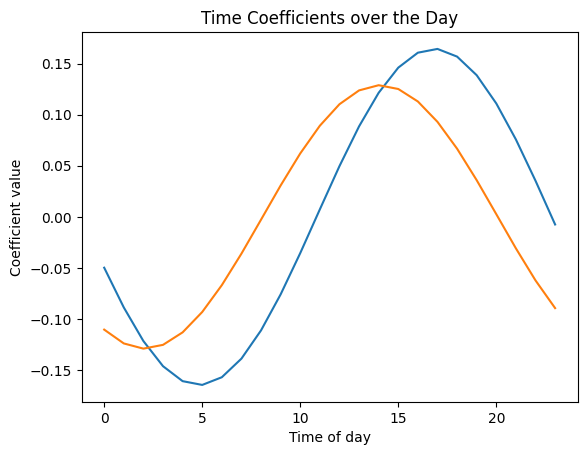

In [ ]:
plt.plot(times, center_time_coeff)
plt.plot(times, other_time_coeff)
plt.xlabel('Time of day')
plt.ylabel('Coefficient value')
plt.title('Time Coefficients over the Day')

In [ ]:
# prompt: Count the percentage of time each column from column_names of est_ratio is above 0.75

# Assuming est_ratio DataFrame is already loaded as in the provided code.
# and column_names is defined as in the provided code.

percentage_above_threshold = {}

for col in column_names:
    percentage = (est_ratio[col] > 0.8).mean() * 100
    percentage_above_threshold[col] = percentage

percentage_above_threshold


{'Gto-Alhondiga': np.float64(0.0),
 'Gto-Alonso': np.float64(8.892164087447801),
 'Gto-Hinojo': np.float64(11.127487103905674),
 'Gto-Pozuelos': np.float64(0.0),
 'Gto-SanPedro': np.float64(0.17194792434291328),
 'Irapuato-Hidalgo': np.float64(1.3264554163596167),
 'Leon-Mariachi': np.float64(1.007123556865635)}